# Forest-Guided Clustering Tutorial

This tutorial is an introduction on how to use the Forest-Guided Clustering python package to interpret your Random Forest model. We will show you:

1. how to install the Forest-Guided Clustering package
2. how to apply the Forest-Guided Clustering package to your trained Random Forest model
3. how to use the output visualizations for interpretation of your Random Forest model


**Note:** The Forest-Guided Clustering method provides insight into the structure of the data by identifying the features that guide the decision process of the Random Forest model. If the trained Random Forest model shows a poor performance, e.g. accuracy of 70% or lower, and therefore, makes poor decisions, the retrieved feature importance might not reflect the true underlying structures in the data.


## Installation

To use the Forest-Guided Clustering you have to install the fgclustering package first.

**Installation of the fgclustering package via PyPi:**

```pip install fgclustering```

**Installation of the fgclustering package via pip from source:**

Clone the git repo and install the downloaded package with:

```git clone https://github.com/HelmholtzAI-Consultants-Munich/fg-clustering.git```

```pip install .        (Installation as python package: run inside directory)```

or if you want to develop the package:

```pip install -e .        (Installation as python package: run inside directory)```

Note: if you are using conda, first install pip with: ```conda install pip```

## Import

In [8]:
## Import the Forest-Guided Clustering package
from fgclustering import FgClustering

## Imports for datasets
from palmerpenguins import load_penguins
from sklearn.datasets import load_breast_cancer, fetch_california_housing

## Additional imports for use-cases
import joblib
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import timeit

## Use Case 1: FGC for Random Forest Classifier (binary classification)

The first use-case is a simple binary classification Random Forest model. The Random Forest classifier is trained based on the Breast Cancer dataset from ```sklearn.datasets``` (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)). This dataset contains 569 samples of 212 malignant (class 0) and 357 benign (class 1) tumors. Tumors are described by 30 numeric features computed from a digitized image taken of breast mass.

In [2]:
data_breast_cancer = load_breast_cancer(as_frame=True)
data_breast_cancer = data_breast_cancer.frame
data_breast_cancer['target'] = data_breast_cancer['target'].map({0: 'malignant', 1: 'benign'})
data_breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


We trained a Random Forest Classifier on the whole dataset and tuned the hyperparameters via 5 fold cross-validation, where we optimized the parameters: ```max_depth``` and ```max_features```. For the sake of simplicity and due to the availability of an out-of-bag score, we did not use train / test splits.

In [3]:
X_breast_cancer = data_breast_cancer.loc[:, data_breast_cancer.columns != 'target']
y_breast_cancer = data_breast_cancer.target

classifier = RandomForestClassifier(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_classifier = GridSearchCV(classifier, grid, cv=5)
grid_classifier.fit(X_breast_cancer, y_breast_cancer)
rf_breast_cancer = grid_classifier.best_estimator_

print(f'Parameters of best prediction model: {grid_classifier.best_params_}')
print(f'OOB accuracy of prediction model: {round(rf_breast_cancer.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'sqrt'}
OOB accuracy of prediction model: 0.954


Now we apply the Forest-Guided Clustering method to understand which features play an important role for the classification of tumors into malignant and benign. We use the pre-processed breast cancer dataset and trained Random Forest Classifier as input for an ```FgClustering``` object. We have to indicate which column of the dataset contains the target values in the ```target_column``` parameter. If the target column is part of the dataset, the string with the column name is passed. If the target variable is not part of the dataset, the vector of target values is passed.

Optional parameters are:

- ```random_state```: Seed number for random state, defaults to 42


In [4]:
fgc = FgClustering(model=rf_breast_cancer, data=data_breast_cancer, target_column='target')

Interpreting RandomForestClassifier


To run the Forest-Guided Clustering method we have to execute the ```run()``` function. This function will calculate the optimal number of clusters as well as the corresponding global and local feature importance for the obtained clusters. Those values are defined as *feature importance = 1 - p-value*, where the p-value indicates the significance of the difference between cluster-wise feature distributions (global feature importance) or the significance that the feature values attributed to a cluster are not randomly drawn from the full feature distribution (local feature importance). 

This function has several optional parameters:

- ```number_of_clusters```: Number of clusters for the k-medoids clustering. Leave *None* if number of clusters should be optimized, defaults to None
- ```max_K```: Maximum number of clusters for cluster score computation, defaults to 8
- ```method_clustering```: Which algorithm to use, defaults to 'pam'. Use 'fasterpam' for big datasets. See python kmedoids documentation for other implemented methods.
- ```init_clustering```: Specify medoid initialization method. See python [kmedoids documentation](https://python-kmedoids.readthedocs.io/en/latest/) for parameter description, defaults to 'random'
- ```max_iter_clustering```: Number of iterations for k-medoids clustering, defaults to 100
- ```discart_value_JI```: Minimum Jaccard Index for cluster stability. Note: a Jaccard Index < 0.6 indicates that the observed pattern is not stable anymore, defaults to 0.6 
- ```bootstraps_JI```: Number of bootstraps to compute the Jaccard Index, defaults to 100
- ```bootstraps_p_value```: Number of bootstraps to compute the p-value of feature importance, defaults to 100
- ```n_jobs```:  maximum number of jobs to run in parallel when creating bootstraps to compute the Jaccard index. n_jobs=1 means no parallel computing is used, defaults to 1
- ```verbose```: print the output of fgc cluster optimization process (the Jaccard index and score for each cluster number); defaults to 1 (printing). Set to 0 for no outputs



If the parameter ```number_of_clusters``` is not specified, the ```run()``` function will compute the optimal number of clusters based on a scoring function that consideres the class mixture of the cluster, the so-called *score* and the cluster stability, the so-called *Jaccard Index*. The lower the *score* the better the separation of target values between cluster (e.g. classes that are well mixed within single clusters imply a high score, while having only one class within each cluster would lead to a low score). The lower the *Jaccard Index* the lower the cluster stability, e.g. if we repeat the clustering on a subsample of the original dataset we will get a very different clustering. The *Jaccard Index* returns values between 0 (unstable) and 1 (stable), where 0.6 is suggested as a good cutoff for stability, i.e. clusters with a *Jaccard Index* > 0.6 are considered as stable (see [Read the Docs documentation](https://forest-guided-clustering.readthedocs.io/en/latest/general_algorithm.html#general-algorithm) for further explanations). 

After optimizing the number of clusters, the k-Medoids clustering algorithm is applied to the distance matrix (which is computed from the Random Forest proximity matrix) where k is the optimal number of clusters. 

In [7]:
fgc.run()

 17%|█▋        | 1/6 [00:00<00:04,  1.01it/s]

For number of cluster 2 the Jaccard Index is 0.9977762891115787
For number of cluster 2 the score is 0.06613635989234057


 33%|███▎      | 2/6 [00:01<00:03,  1.06it/s]

For number of cluster 3 the Jaccard Index is 0.8861827734206449
For number of cluster 3 the score is 0.07478999977783318


 50%|█████     | 3/6 [00:03<00:03,  1.16s/it]

For number of cluster 4 the Jaccard Index is 0.5036478848646798
Clustering is instable, no score computed!


 67%|██████▋   | 4/6 [00:05<00:03,  1.51s/it]

For number of cluster 5 the Jaccard Index is 0.5934978039560798
Clustering is instable, no score computed!


 83%|████████▎ | 5/6 [00:08<00:01,  1.97s/it]

For number of cluster 6 the Jaccard Index is 0.33292910886203164
Clustering is instable, no score computed!


100%|██████████| 6/6 [00:11<00:00,  1.97s/it]

For number of cluster 7 the Jaccard Index is 0.43566831779331777
Clustering is instable, no score computed!
Optimal number of cluster is: 2


<font color='red'> The optimal number of clusters for the breast cancer dataset is *k=2*. We can see from the output above that *k=2* leads to the lowest *score* of 0.06 while having a *Jaccard Index* of 0.98, which means that the clustering is almost perfectly stable. Clusterings with k between 3 and 6 have stable clustering as well but higher scores, and hence, the seperation of target values between clusters is less god, e.g. higher class-mixture within a cluster. The clustering with 7 clusters has a *Jaccard Index* < 0.6 and hence is defined unstable and not considered for the choice of the optimal k. </font>

In a second step, we use the significance of the difference between cluster-wise feature distributions as a measure of global feature importance (ANOVA for continuous features and chi square for categorical features). Features that have significantly different distributions across clusters have a high feature importance, while features that have a similar feature distribution across clusters have a low feature importance. Those features are considered to be less important in the decision making process of the Random Forest model (see description [here](https://forest-guided-clustering.readthedocs.io/en/latest/feature_importance.html#global-feature-importance) for further explanations).

To plot the global feature importance, we run the ```plot_global_feature_importance()``` function. The resulting plots can be saved by setting the ```save``` parameter. The plot below shows that most features except the last four show significant differences across clusters.

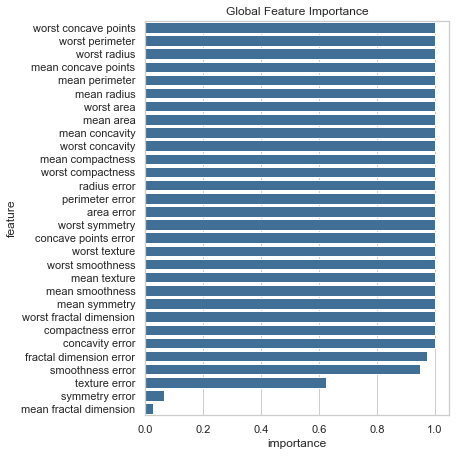

In [8]:
fgc.plot_global_feature_importance()

In addition to the global feature importance, we also provide a local feature importance which gives the importance of each feature for each cluster. For the local feature importance we pre-filter the features based on the global feature importance (```thr_pvalue``` is used for this filtering step). Here, a feature is considered important if its distribution in a particlular cluster is clearly different from the feature distribution in the whole dataset. E.g. if the feature values in a certain cluster would be spread over the whole feature range, the feature would not be considered important for the interpretation of the clusters because it does not show any trend or pattern that differentiates the clusters and hence, we would not be able to draw any clear conclusions from it (see description [here](https://forest-guided-clustering.readthedocs.io/en/latest/feature_importance.html#local-feature-importance) for further explanations).

To plot the local feature importance, we run the ```plot_local_feature_importance()``` function. The resulting plots can be saved by setting the ```save``` parameter. 

Optional parameters are:

- ```thr_pvalue```: p-value threshold for global feature importance filtering, defaults to 1 (no filtering)

The plot below shows that both clusters have some important features in common. However, for cluster 1 much less features show a clear pattern than for cluster 0.

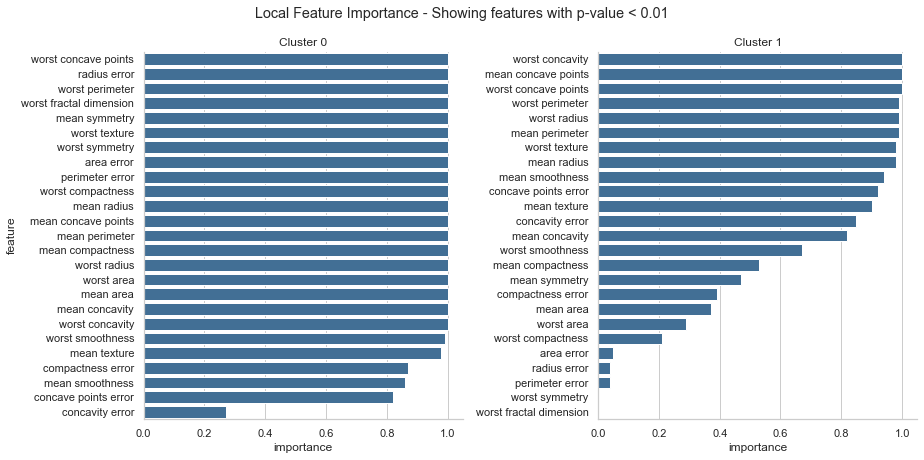

In [9]:
fgc.plot_local_feature_importance(thr_pvalue=0.01) #only plot relevant features

Forest-Guided Clustering provides the special option to visualize the decision path of a Random Forest model, reflecting the decision making process of that model, in a heatmap summary plot and a feature-wise distribution plot. The heatmap provides a general overview on the target value attribution and feature enrichment / depletion per cluster.  We can see which classes/target values fall into which cluster and samples that fall into the "wrong" cluster can be inspected further as they might be extreme outliers or wrongly labelled samples / measurement errors. The distribution plots contain the same information as the heatmap just presented in a different way. Here the features are not standardized and we can see the actual scale of each feature on the y axis. Furthermore, we get an idea of the distribution of feature values within each cluster, e.g. having a small or high within-cluster-variation. 

To plot the decision path, we run the ```plot_decision_paths()``` function. The resulting plots can be saved by setting the ```save``` parameter. 

Optional parameters are:

- ```thr_pvalue```: p-value threshold for global feature importance filtering, defaults to 1 (no filtering)
- ```distributions```: plot the distributions of each feature passing the significance threshold for filtering, defaults to True
- ```heatmap```: plot the heatmap with features passing the significance threshold for filtering, defaults to True

Here, we don't pre-filter the features by global feature importance to show that the last four features, which were identified as non-important by the global feature importance, indeed don't show any considerable difference in feature values across clusters.

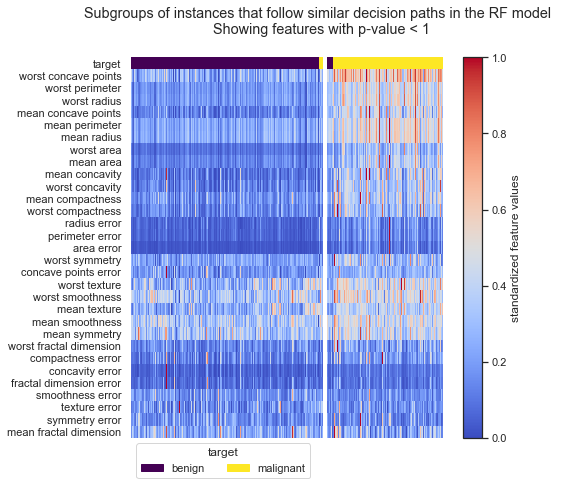

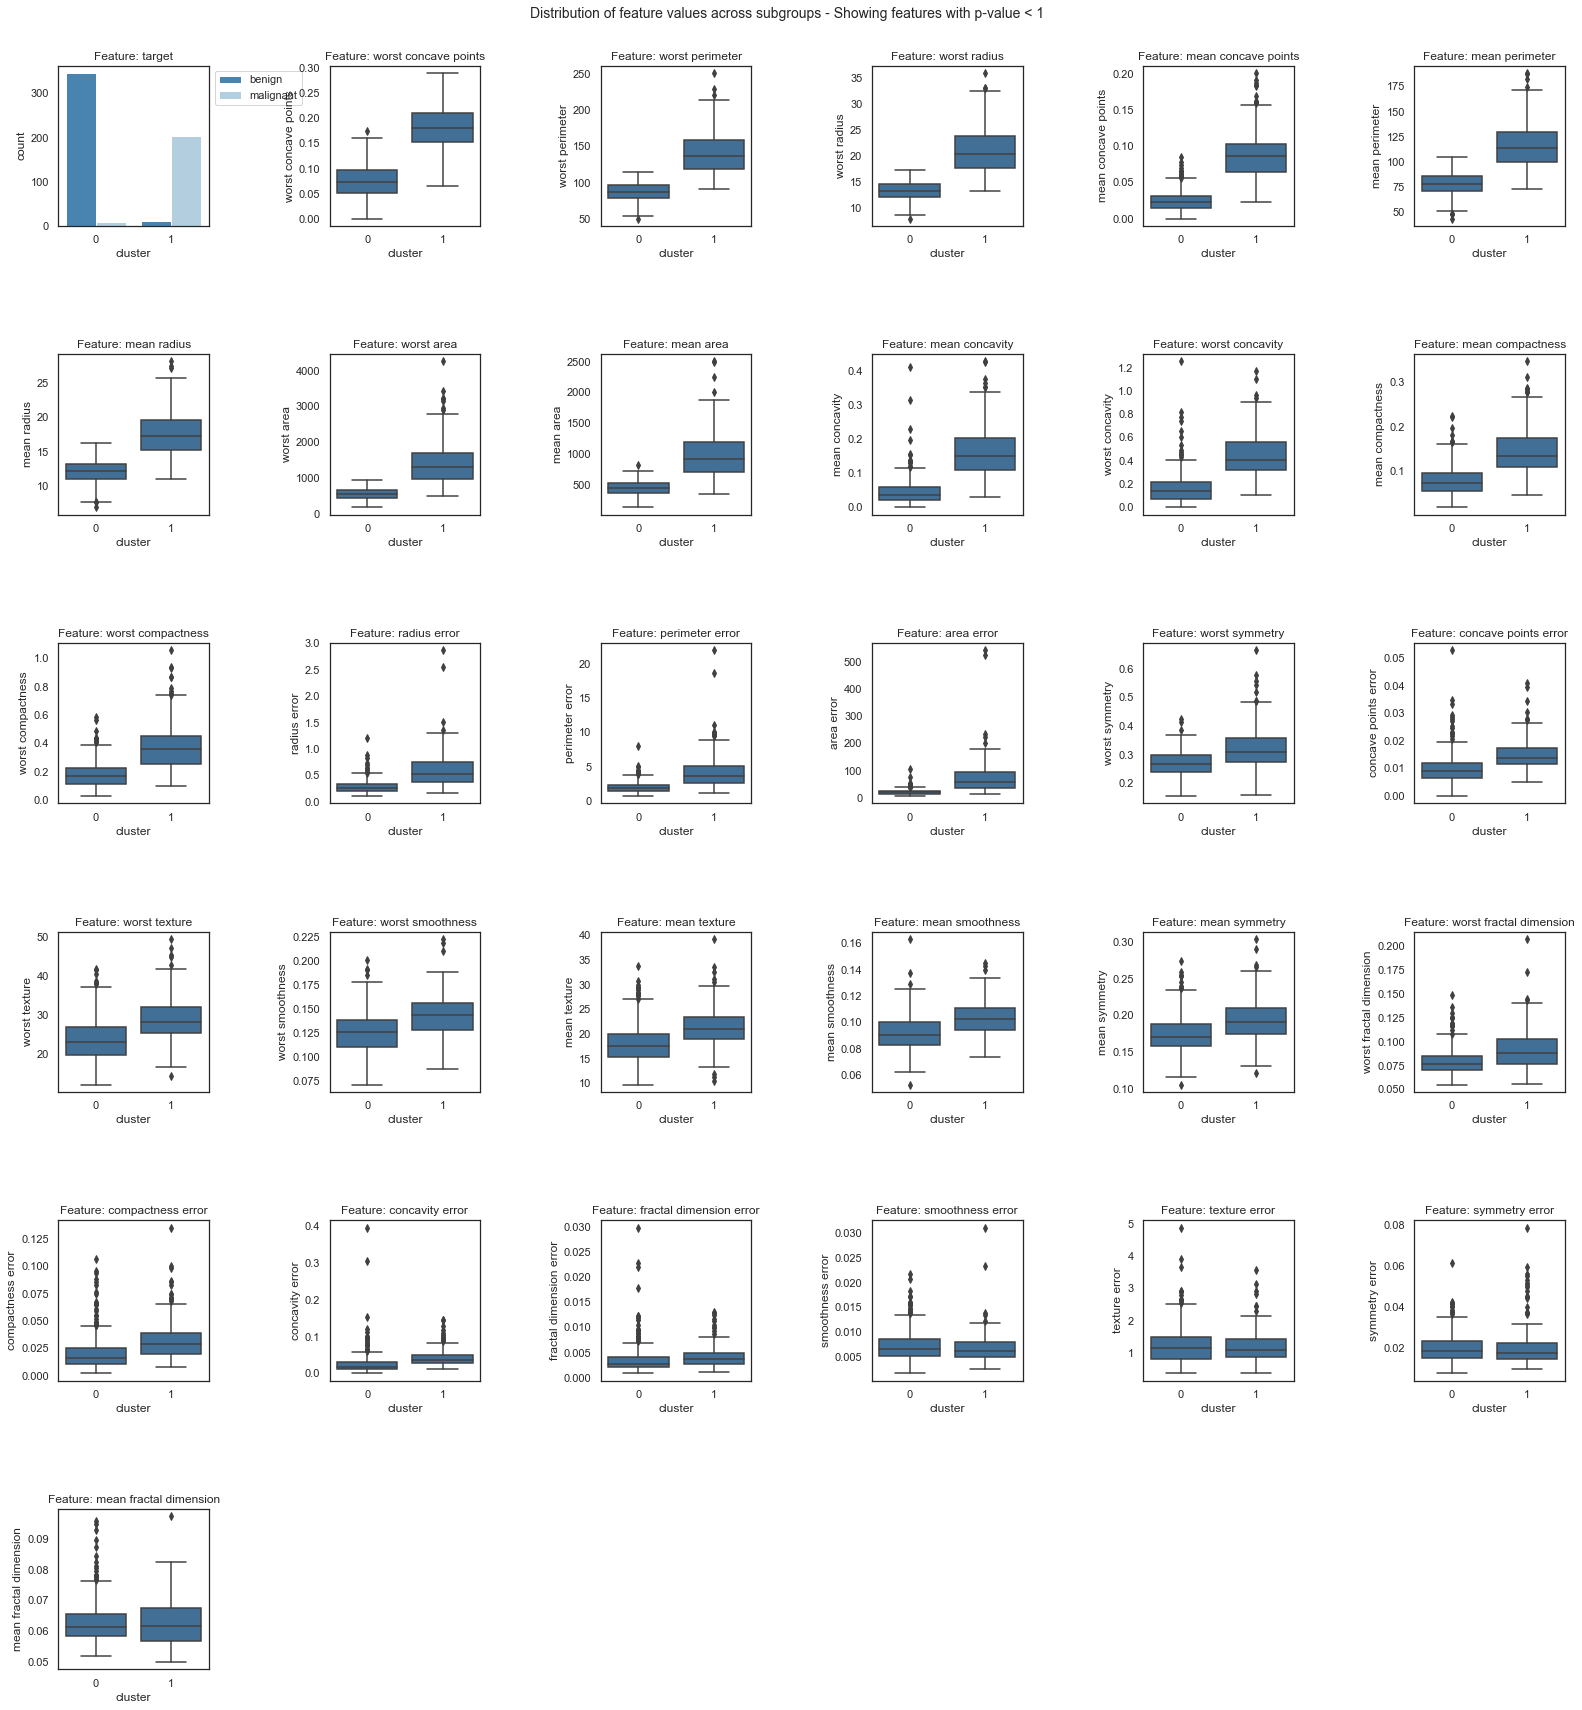

In [10]:
fgc.plot_decision_paths(thr_pvalue=1) 

From the resulting plots we can draw the following conclusions for malignent and benign tumors:

- The two classes are almost perfectly attributed to the two clusters. Only a few samples fall into the "wrong" cluster, which could be further inspected to rule out labelling errors.
- The top ranked features in the boxplots and feature importance show the biggest difference of feature values between cluster.
- Cluster 0 samples (benign tumors) have lower values for all important features than cluster 1 samples (malignant tumors), i.e. malignent tumors have more worst concave points, a higher compactness and a larger radius and perimeter.

## Use Case 2: FGC for Random Forest Classifier (multiclass classification)

The second use-case illustrates how Forest-Guided Clustering can be used to interpret a multi-class classificiation model. The Random Forest classifier is trained on the Penguin dataset from ```palmerpenguins``` (for more details please see descrption [here](https://github.com/mcnakhaee/palmerpenguins)). This dataset contains 344 penguins observed on islands in the Palmer Archipelago near Palmer Station, Antarctica. The dataset contains three classes of penguins: 146 Adelie, 68 Chinstrap and 119 Gentoo penguins. The penguins are described by different characteristics, such as size measurements, clutch observations, blood isotope ratios and sex, encoded in numeric and categorical features.

In [9]:
data_penguins = load_penguins()

# Remove the instances with missing values and check how many we are left with
print(f"Before omiting the missing values the dataset has {data_penguins.shape[0]} instances")
data_penguins.dropna(inplace=True)
print(f"After omiting the missing values the dataset has {data_penguins.shape[0]} instances")

data_penguins.head()

Before omiting the missing values the dataset has 344 instances
After omiting the missing values the dataset has 333 instances


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


We trained a Random Forest Classifier on the whole dataset and tuned the hyperparameters via 5 fold cross-validation, where we optimized the parameters: ```max_depth``` and ```max_features```. For the sake of simplicity and due to the availability of an out-of-bag score, we did not use train / test splits. To use the categorical feature for our Random Forest Classifier, we one-hot encode those features, using dummy encoding.

In [10]:
# preprocess categorical features such that they can be used for the RF model
data_penguins_encoded = pd.get_dummies(data_penguins, columns=['island', 'sex'], prefix=['island', 'sex'], drop_first=True)

X_penguins = data_penguins_encoded.loc[:, data_penguins_encoded.columns != 'species']
y_penguins = data_penguins_encoded.species

classifier = RandomForestClassifier(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_classifier = GridSearchCV(classifier, grid, cv=5)
grid_classifier.fit(X_penguins, y_penguins)
rf_penguins = grid_classifier.best_estimator_

print(f'Parameters of best prediction model: {grid_classifier.best_params_}')
print(f'OOB accuracy of prediction model: {round(rf_penguins.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'sqrt'}
OOB accuracy of prediction model: 0.985


We apply the Forest-Guided Clustering method to understand which characteristics play an important role for the classification of the different penguin species. We use the pre-processed penguins dataset and trained Random Forest Classifier as input for the ```FgClustering``` object and execute the ```run()``` function. For further description of the input parameters see binary classification example above.

In [11]:
fgc = FgClustering(model=rf_penguins, data=data_penguins_encoded, target_column='species')
fgc.run()

Interpreting RandomForestClassifier


 17%|█▋        | 1/6 [00:00<00:01,  4.93it/s]

For number of cluster 2 the Jaccard Index is 0.9160289493578838
For number of cluster 2 the score is 0.32933697175607646


 33%|███▎      | 2/6 [00:00<00:01,  3.75it/s]

For number of cluster 3 the Jaccard Index is 0.9952883877989059
For number of cluster 3 the score is 0.018666445142142996


 50%|█████     | 3/6 [00:00<00:01,  2.86it/s]

For number of cluster 4 the Jaccard Index is 0.9718654376806184
For number of cluster 4 the score is 0.07721157852502875


 67%|██████▋   | 4/6 [00:01<00:00,  2.14it/s]

For number of cluster 5 the Jaccard Index is 0.542860857827226
Clustering is instable, no score computed!


 83%|████████▎ | 5/6 [00:02<00:00,  1.63it/s]

For number of cluster 6 the Jaccard Index is 0.8737253192050606
For number of cluster 6 the score is 0.02112436148148152


100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

For number of cluster 7 the Jaccard Index is 0.4526426851667004
Clustering is instable, no score computed!
Optimal number of cluster is: 3


We can see from the output above that the optimal number of clusters is *k=3*, which leads to the lowest *score* while having a stable clustering. When plotting the global feature impotance, we can see that the encoded categorical features have one feature per encoding, i.e. the feature *island* has three categories (Dream, Torgersen and Biscoe) and is encoded by two dummy variables *island_Drean* and *island_Torgersen*. 

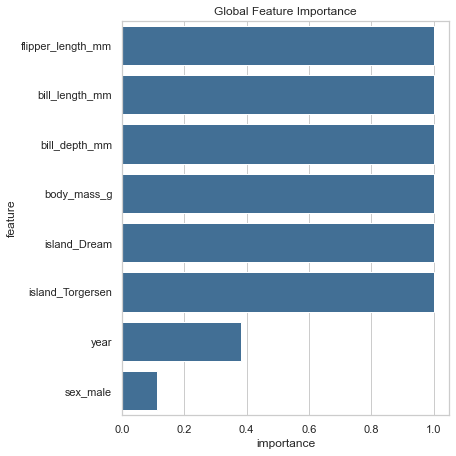

In [15]:
fgc.plot_global_feature_importance()

This encoding makes the interpretation of categorical features more difficult and prevents the usage of an appropriate test statistic for categorical features, e.g. the chi-square test. To overcome this problem, we can use a different feature matrix for the calculation of the test statistics on which the global and local feature importance as well as the decision path plots are based on. **Note:** the new feature matrix must have the same number of samples and the same ordering of samples as the original feature matrix to coincide with the calculated proximity matrix. In the case of our penguins dataset, we can exchange the dummy encoded features with the original categorical features and use the funtion ```calculate_statistics()``` to recalculate the p-values for each feature (over all clusters and per cluster) based on the new feature matrix.


In [16]:
data_penguins['island'] = data_penguins['island'].astype('category')
data_penguins['sex'] = data_penguins['sex'].astype('category')

fgc.calculate_statistics(data=data_penguins, target_column='species')

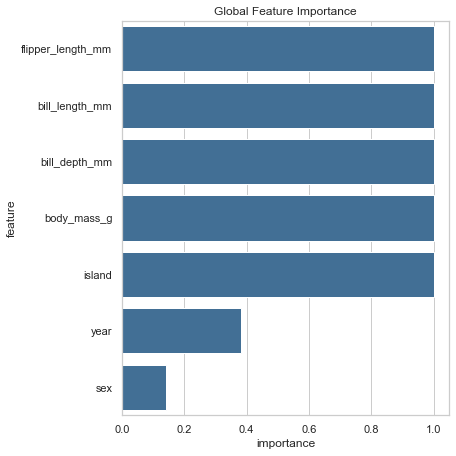

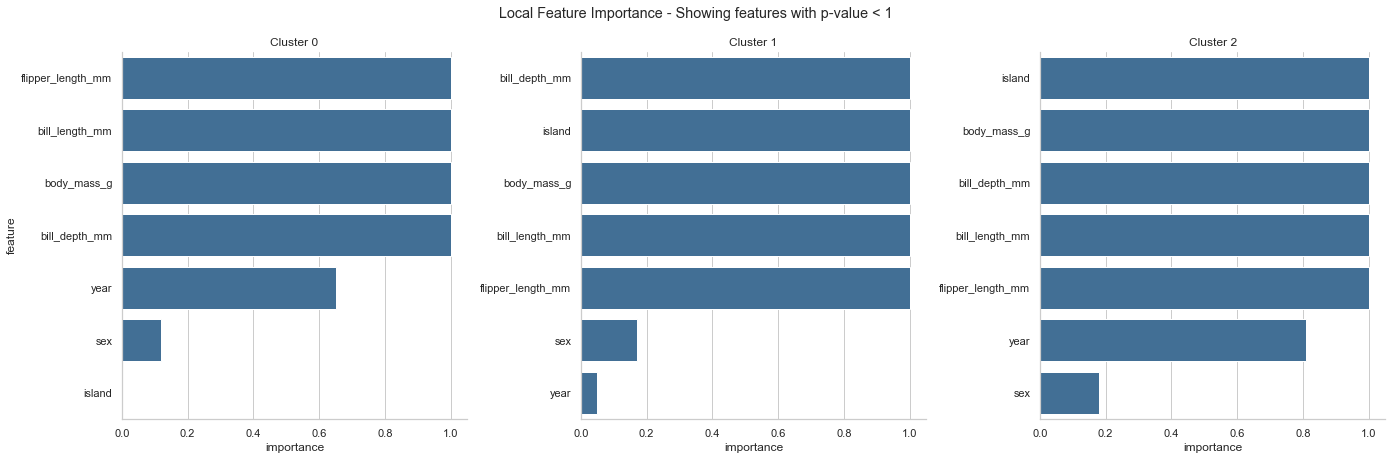

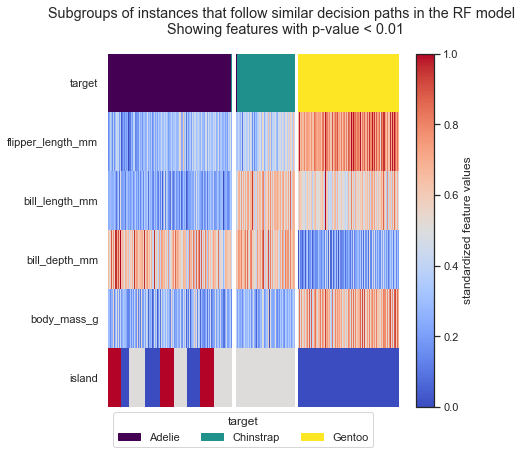

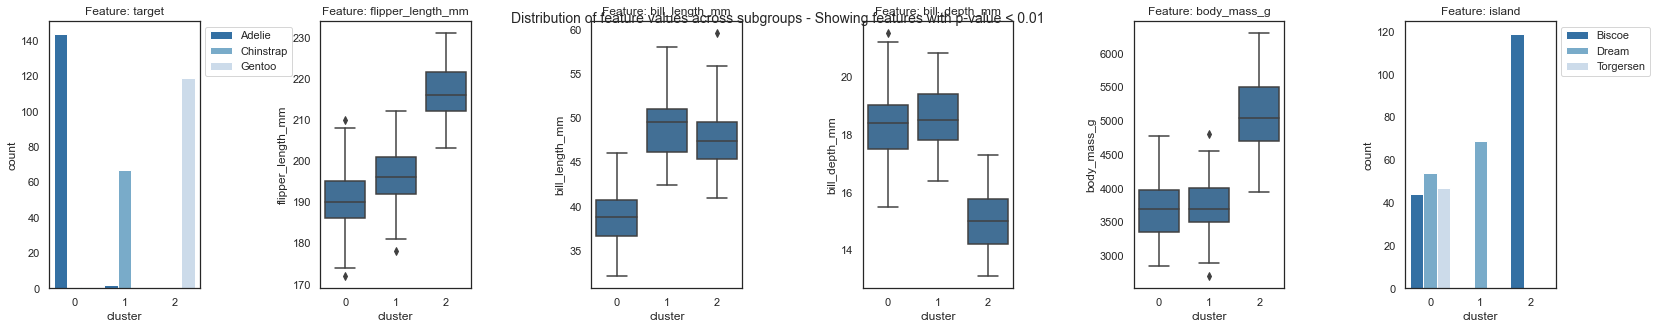

In [17]:
fgc.plot_global_feature_importance()
fgc.plot_local_feature_importance()
fgc.plot_decision_paths(thr_pvalue=0.01) #only plot relevant features

From the resulting plots we can draw the following conclusions:

- The three classes are almost perfectly attributed to the three clusters. Only a few samples of *Adelie* penguins fall into the "wrong" cluster, which could be further inspected.
- All features, except *year* and *sex*, are important for the clustering and show a clear trend within each cluster.
- Cluster 0 only contains *Adelie* penguins. *Adelie* penguins are found on all three islands and are described by a small flipper and bill length, a low body mass and a long bill depth. 
- Cluster 2 only contains *Gentoo* penguins. Those penguins show the opposite characteristic than *Adelie* penguins, i.e. long flipper and bill length, a high body mass but a short bill depth, but are only found the *Dream* island.
- Cluster 1 almost exclusively contains *Chinstrap* penguins. *Chinstrap* penguins have a small flipper length and body mass, but a long bill length and depth. Those penguins are exclusively found on the Biscoe island.

## Use Case 3: FGC for Random Forest Regressor

The third use-case illustrates how Forest-Guided Clustering can be used to interpret a regression model. The Random Forest Regressor is trained on the California Housing dataset from ```sklearn.datasets``` (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)). This dataset contains 20,640 median house values for California districts (expressed in $100,000), which are described by 8 numeric feature.

In [19]:
data_housing = fetch_california_housing(as_frame=True)
data_housing = data_housing.frame

# for sake of runtime we only use the first 1000 samples
data_housing = data_housing.iloc[:1000]
data_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We trained a Random Forest Regressor on the whole dataset and tuned the hyperparameters via 5 fold cross-validation, where we optimized the parameters: ```max_depth``` and ```max_features```.  For the sake of simplicity and due to the availability of an out-of-bag score, we did not use train / test splits.

In [20]:
X_housing = data_housing.loc[:, data_housing.columns != 'MedHouseVal']
y_housing = data_housing.MedHouseVal

regressor = RandomForestRegressor(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_regressor = GridSearchCV(regressor, grid, cv=5)
grid_regressor.fit(X_housing, y_housing)
rf_housing = grid_regressor.best_estimator_

print(f'Parameters of best prediction model: {grid_regressor.best_params_}')
print(f'OOB R^2 of prediction model: {round(rf_housing.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'log2'}
OOB R^2 of prediction model: 0.74


We apply the Forest-Guided Clustering method to understand the relation between housing values and the provided features (e.g. median income, house age etc.). We use the pre-processed california housing dataset and trained Random Forest Regressor as input for the ```FgClustering``` class and execute the ```run``` function. For further description of the input parameters see binary classification example above.

In [21]:
fgc = FgClustering(model=rf_housing, data=data_housing, target_column='MedHouseVal')
fgc.run()

Interpreting RandomForestRegressor


 17%|█▋        | 1/6 [00:01<00:08,  1.68s/it]

For number of cluster 2 the Jaccard Index is 0.864165718623012
For number of cluster 2 the score is 788.7082410247665


 33%|███▎      | 2/6 [00:04<00:10,  2.62s/it]

For number of cluster 3 the Jaccard Index is 0.5504154901275099
Clustering is instable, no score computed!


 50%|█████     | 3/6 [00:09<00:11,  3.70s/it]

For number of cluster 4 the Jaccard Index is 0.854894647734879
For number of cluster 4 the score is 333.5488671501794


 67%|██████▋   | 4/6 [00:17<00:10,  5.12s/it]

For number of cluster 5 the Jaccard Index is 0.5073744308706809
Clustering is instable, no score computed!


 83%|████████▎ | 5/6 [00:27<00:06,  6.90s/it]

For number of cluster 6 the Jaccard Index is 0.6457584705396698
For number of cluster 6 the score is 290.78214021419785


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]

For number of cluster 7 the Jaccard Index is 0.4176482607448857
Clustering is instable, no score computed!
Optimal number of cluster is: 6


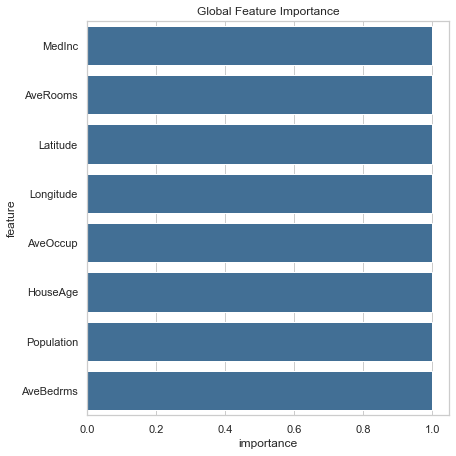

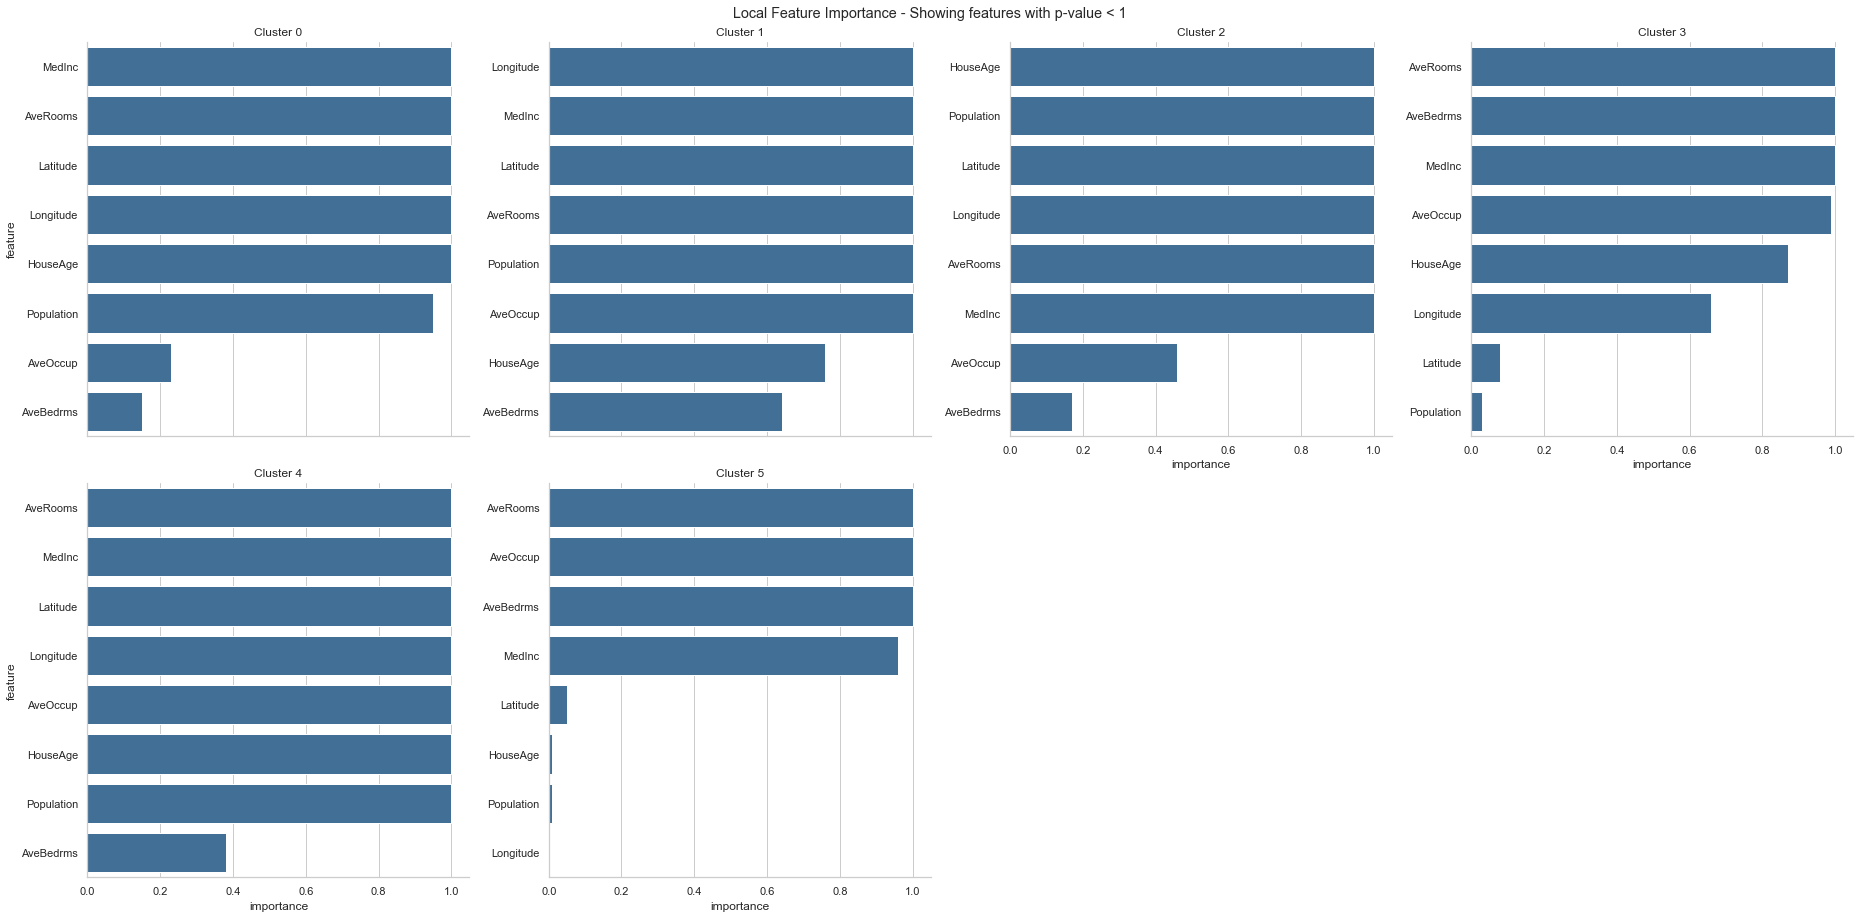

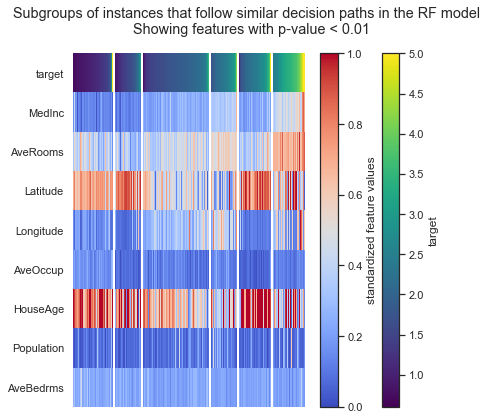

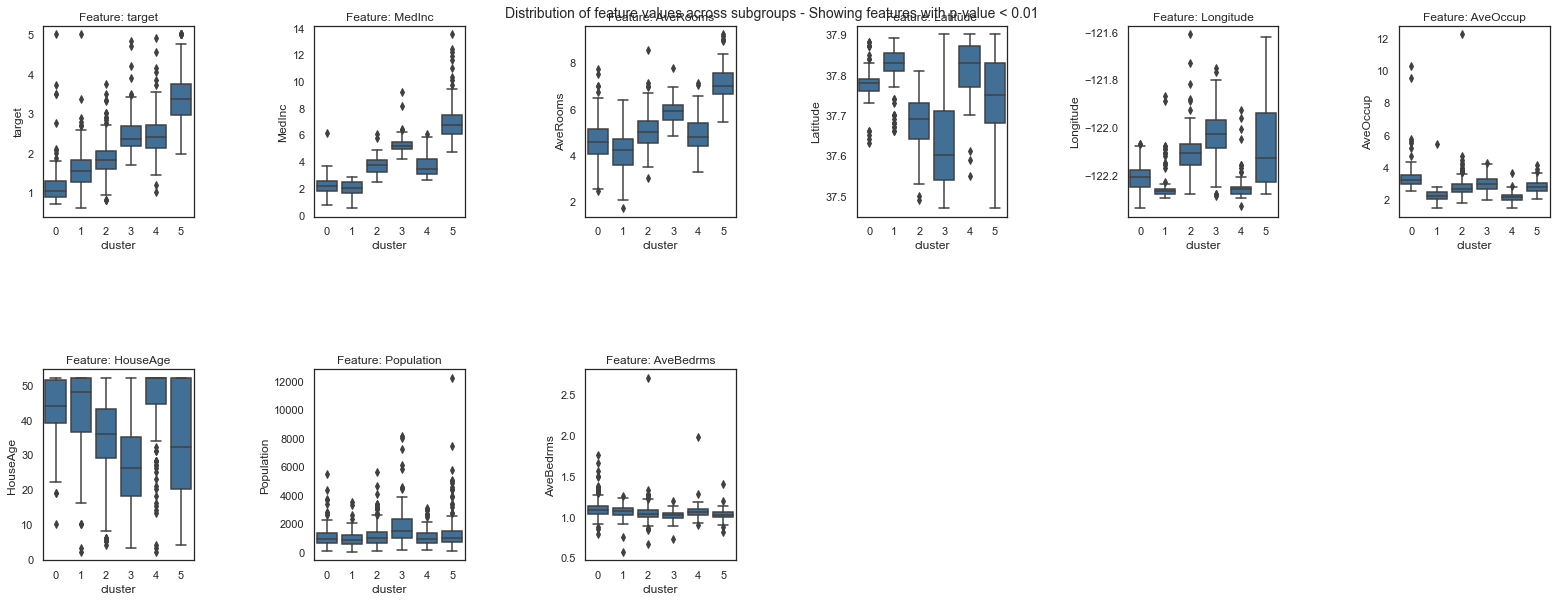

In [22]:
fgc.plot_global_feature_importance()
fgc.plot_local_feature_importance()
fgc.plot_decision_paths(thr_pvalue=0.01) #only plot relevant features

<font color=red> 
From the resulting plots we can draw the following conclusions:

- Cluster 0 and cluster 3 contain the lowest and highest house values, respectively. Clusters 1 and 2 contain houses with intermediate values.
- Low and high value houses are located in close by areas, according to the *Latitude* and *Longitude* coordiantes. However, mainly people with lower medium income are living in lowly valued houses compared to highly valued houses, which are inhabited by people with high medium income. Furthermore, lowly priced houses are older and have less number of rooms.
- When we compare the two clusters with intermediate valued houses, we see that they are located in different areas, according to the *Latitude* and *Longitude* coordiantes and also differ in house age. 
- The features *Population* and *AveBedrms* contain some extreme outlier, which most likely lead to the significance of those features. One would have to further inspect what kind of role those outlier play in the dataset and what influence they might have on the regression model.
</font>

## Special Case 1: Inference with FGC

The first special case illustrates how we can use FGC to do inference on unseen data. When training a Random Forest model, we often divide the data into a training and test set because we are interested in understanding how well the Random Forest model generalizes to new data. This generalization is often only measured with performance metrics, however FGC also allows us to see how well the concluded explanations generalize to new unseen data. To showcase how FGC can be used during inference time, we will use the California Housing dataset again (for dataset description, please see *Use Case 3*). 

In [27]:
data_housing = fetch_california_housing(as_frame=True)
data_housing = data_housing.frame

We will used the first 1000 samples of the dataset as training data to train a Random Forest Regressor, where we tuned the *max_depth* and *max_features* parameters with 5-fold corss-validation.

In [28]:
data_housing_train = data_housing.iloc[:1000]
X_housing_train = data_housing_train.loc[:, data_housing_train.columns != 'MedHouseVal']
y_housing_train = data_housing_train.MedHouseVal

regressor = RandomForestRegressor(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_regressor = GridSearchCV(regressor, grid, cv=5)
grid_regressor.fit(X_housing_train, y_housing_train)
rf_housing = grid_regressor.best_estimator_

print(f'Parameters of best prediction model: {grid_regressor.best_params_}')
print(f'OOB R^2 of prediction model: {round(rf_housing.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'log2'}
OOB R^2 of prediction model: 0.74


To understand the relation between housing values and the provided features (e.g. median income, house age etc.), we apply the Forest-Guided Clustering method on the training dataset and the trained Random Forest model.

Interpreting RandomForestRegressor


 17%|█▋        | 1/6 [00:01<00:07,  1.54s/it]

For number of cluster 2 the Jaccard Index is 0.864165718623012
For number of cluster 2 the score is 788.7082410247665


 33%|███▎      | 2/6 [00:04<00:10,  2.56s/it]

For number of cluster 3 the Jaccard Index is 0.5504154901275099
Clustering is instable, no score computed!


 50%|█████     | 3/6 [00:09<00:11,  3.69s/it]

For number of cluster 4 the Jaccard Index is 0.854894647734879
For number of cluster 4 the score is 333.5488671501794


 67%|██████▋   | 4/6 [00:16<00:10,  5.06s/it]

For number of cluster 5 the Jaccard Index is 0.5073744308706809
Clustering is instable, no score computed!


 83%|████████▎ | 5/6 [00:26<00:06,  6.82s/it]

For number of cluster 6 the Jaccard Index is 0.6457584705396698
For number of cluster 6 the score is 290.78214021419785


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]

For number of cluster 7 the Jaccard Index is 0.4176482607448857
Clustering is instable, no score computed!
Optimal number of cluster is: 6


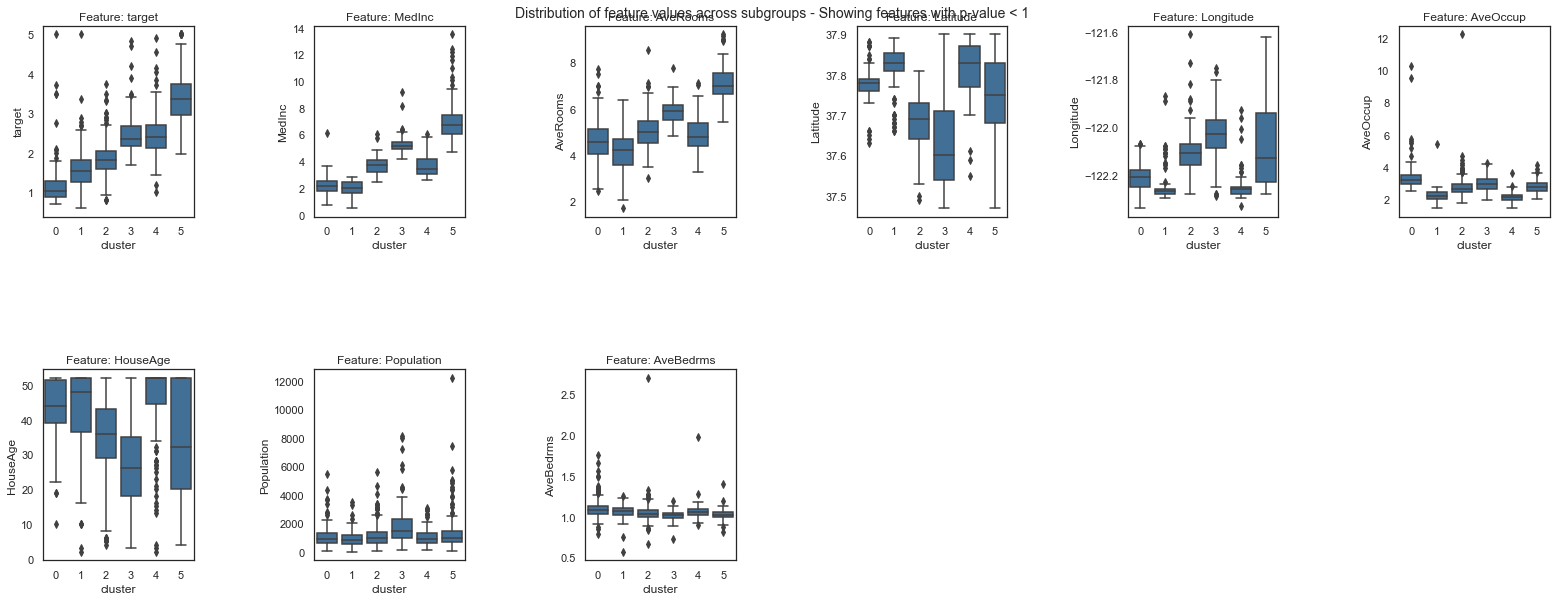

In [29]:
fgc = FgClustering(model=rf_housing, data=data_housing_train, target_column='MedHouseVal')
fgc.run()

fgc.plot_decision_paths(heatmap=False) 

Next, we will use the another 1000 samples of the California Housing dataset as test data and calculate the performance of the random Forest on the test set.

In [31]:
data_housing_test = data_housing.iloc[6000:7000]
data_housing_test.reset_index(inplace=True, drop=True)
X_housing_test = data_housing_test.loc[:, data_housing_test.columns != 'MedHouseVal']
y_housing_test = data_housing_test.MedHouseVal

print(f'Test Set R^2 of prediction model: {round(rf_housing.score(X_housing_test, y_housing_test),3)}')

Test Set R^2 of prediction model: 0.562


As we can see above, the performance on the test set decreased compared to the training set. Hence, we are interested to know, which relations between the housing value and the provided features, that we identified using the training set, still hold and which don't. Therefore, we run FGC on the Random Forest model (trained on the training data) and the test data.

<font color=red> TODO: change below to the right number of clusters </font>

Interpreting RandomForestRegressor
Use 4 as number of cluster


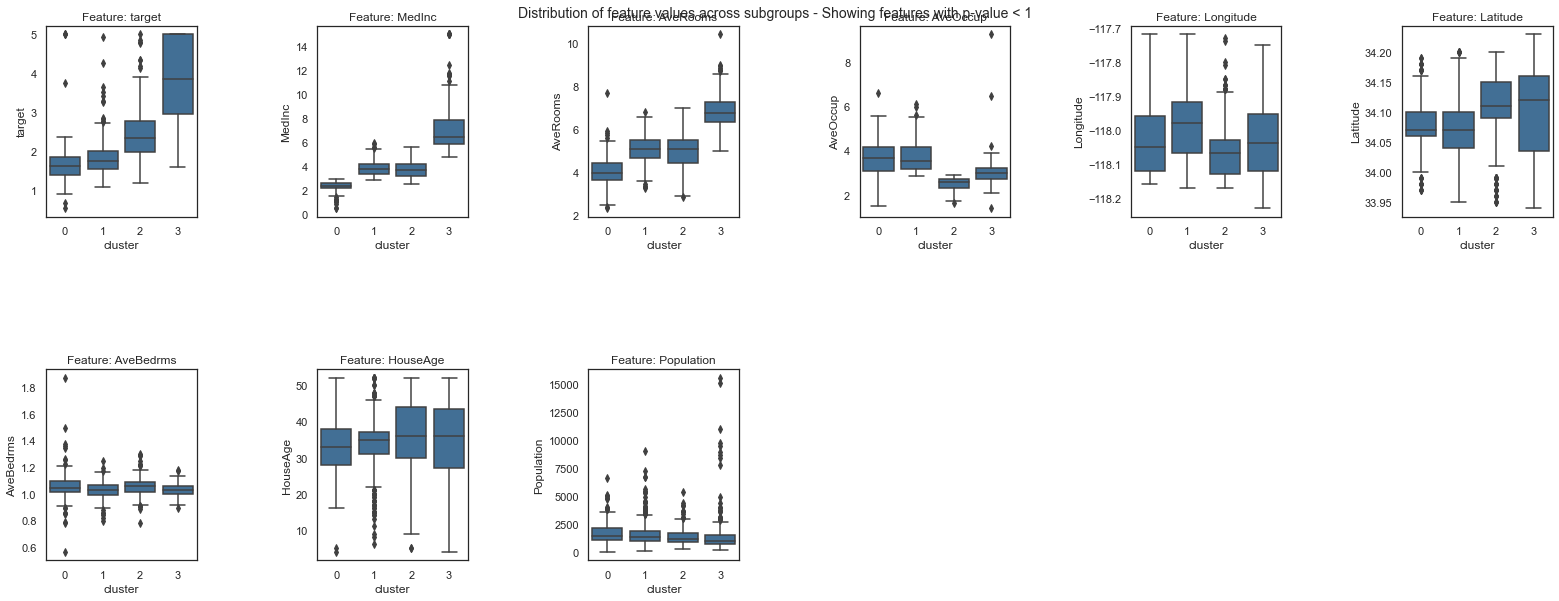

In [34]:
fgc = FgClustering(model=rf_housing, data=data_housing_test, target_column='MedHouseVal')
fgc.run(number_of_clusters=4) 

fgc.plot_decision_paths(heatmap=False)

<font color=red> Comparing the boxplots of FGC run on the training vs test data, we can see that we have communalities but also differences between both datasets. For instance, the feature *MedInc*, *AveRooms* and *AveOccup* show the same trend for the training and test set. On the other hand, features like *Latitude* and *Longitude* don't contribute to the distinction of the two cluster with the intermediate valued houses and also *House Age* shows no significant trend for any of the cluster. This might also explain why the model is performing worse on the test set. It probably picked up some patterns that are specific for the training set but can't be generalized. </font>

### Special Case 2: Impact of Model Complexity on FGC

To Do

### Special Case 3: FGC for Big Data

The third special case illustrates how we can use FGC with big datasets. The base of the FGC is the symmetric proximity matrix calculated for the trained Random Forest model. In the case of a lot of samples in your dataset, the calculation of the matrix, the bootstrapping of it (in the process of finding the optimal cluster number), as well as finding k clusters with k-Medoids algorithm can get computationally demanding. Here, we want to show what you can do to speed-up the process and get the insights you need on your big dataset with the help of FGC. 

Keep in mind that when FGC is asked to optimize the cluster number, i.e. when the number_of_clusters = None (default), it will have to compute the cluster labels for each possible k (up to ```max_K```) and for each of ```bootstraps_JI``` bootstrap samples which can lead to a lot of runs of K-Medoids algorithm in the background. For example, for checking whether 2, 3, 4 or 5 is the optimal cluster number for your dataset with 100 bootstrap iterations for Jaccard Index calculation, the K-medoids will be called 4 + 4*100 = 404 times. Moreover, the bigger your dataset in terms of number of samples (N), the bigger is the distance matrix (N x N) the K-Medoids algorithm needs to work with. Hence, it is definitely worth thinking how to speed up the whole process.

In this Special Case, we will again be using the California housing dataset which was with its 20,640 samples already big enough to significantly slow down the process. We will train the Random Forest model on the full dataset, but will reduce the number of samples to 1000 for the inference with FGC for illustration and timing.

In [2]:
# Load the data
data_housing = fetch_california_housing(as_frame=True).frame

# Train the model (same code as in the Use Case 3)
X_housing = data_housing.loc[:, data_housing.columns != 'MedHouseVal']
y_housing = data_housing.MedHouseVal

regressor = RandomForestRegressor(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_regressor = GridSearchCV(regressor, grid, cv=5)
grid_regressor.fit(X_housing, y_housing)
rf_housing = grid_regressor.best_estimator_

print(f'Parameters of best prediction model: {grid_regressor.best_params_}')
print(f'OOB R^2 of prediction model: {round(rf_housing.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'log2'}
OOB R^2 of prediction model: 0.663


In [4]:
# Reduce the dataset size for FGC:
data_housing_fgc = data_housing.iloc[:1000]

# create the fgc object
fgc = FgClustering(model=rf_housing, data=data_housing_fgc, target_column='MedHouseVal')

Interpreting RandomForestRegressor


First, we will time the default FGC run to be able to compare it to the faster setup we will introduce below. We will change the default settings for the number of bootstrap samples for Jaccard index calculation to 5 and the maximum K value to 7 (```bootstraps_JI``` and ```max_K```, respectively). Other parameters are kept default, but below we are emphasising the ones that will need to be changed later on: 

In [5]:
# verbose = 0 for no output from fgc
timeit.timeit(lambda: fgc.run(method_clustering = 'pam', max_K = 7, bootstraps_JI = 50, n_jobs = 1, verbose = 0), number=10)

Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6


146.32784166699997

As you see, for our __current set-up__ FGC needed on average __146.3 seconds__. This will be our baseline for further comparison.

#### Parallelize the boostrapping process by setting n_jobs > 1

Use the cores you have at your disposal to parallelize the calculation of Jaccard index across bootstrapped samples. You can do so by specifying the parameter ```n_jobs``` in the ```run()``` function. Special cases involve:
- If 1 is given, no parallel computing code is used at all, which is a default setup in FGC
- -1 means using all processors

Now, we will run the same fgc set-up as above, but with 5 (```n_jobs```) concurrently running jobs: 


In [6]:
timeit.timeit(lambda: fgc.run(method_clustering = 'pam', max_K = 7, bootstraps_JI = 50, n_jobs = 5, verbose = 0), number=10)

Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6


63.817510083999935

By specifying the __n_jobs > 1__, i.e. running some __jobs in parallel__, we increased the speed of FGC and now it needed __63.8 seconds__ on average.

#### Use _fasterpam_ method for K-Medoids

[k-medoids package](https://python-kmedoids.readthedocs.io/en/latest/) offers a fast implementation of _PAM_ method used in K-Medoids algorithm. Specifying the ```method_clustering``` parameter in the ```run()``` function will do the trick for you and make the process of calculating cluster labels in FGC much faster. 

Compared to our baseline run, we will change only the ```method_clustering``` to _fasterpam_:

In [8]:
timeit.timeit(lambda: fgc.run(method_clustering = 'fasterpam', max_K = 7, bootstraps_JI = 50, n_jobs = 1, verbose = 0), number=10)

Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6


62.70509625

Compared to baseline example, changing only the __method_clustering__ to __fasterpam__ increased the speed of FGC - now it needed __62.7 seconds__ on average.

<font color=blue>__Note:__ See how across different iterations done for timing purposes, FGC was not super consistent with the cluster number chosen. However, keep in mind we are using just 1000 samples, while the Random Forest model was trained on 20,640 and we also reduced the number of bootstrap samples, which with that sample number might not be enough.</font>

#### Combine the approaches if possible

We find it best, if possible of course, to combine both of the above aspects: 

In [10]:
timeit.timeit(lambda: fgc.run(method_clustering = 'fasterpam', max_K = 7, bootstraps_JI = 50, n_jobs = 5, verbose = 0), number=10)

Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 5
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 6
Optimal number of cluster is: 5
Optimal number of cluster is: 6
Optimal number of cluster is: 6


44.49806695799998

Compared to baseline example, changing both the __method_clustering__ to __fasterpam__ and setting __n_jobs >1__ increased the speed of FGC - now it needed __44.5 seconds__ on average. Hence, this strategy is a clear winner in our example and this difference should get even larger with larger matrices.

#### Subsampling

In case none of the above speed-up tips work for you because your dataset is simply that big or you don't have much time on your disposal, you can try a subsampling strategy we will briefly introduce here. Of course, combining it with any of the previous approaches is possible.

We will assume that you do not know the cluster number in your data and that you want FGC to optimize it. What you could do is approximate the cluster number by subsampling your dataset as many times you want and decide on the cluster number by taking the majority vote from the iterations (just like the Random Forest Classifier takes the majority vote across the trees for the class prediction). 

Please note that the number of iterations and subsample size should be set-up properly and with the total number of samples in mind. If you set the sample size and number of iterations to too low numbers, you might not get the good approximation of your big dataset. 

We will use the same data as before, reduced in size for the sake of this example:

In [3]:
# Reduce the dataset size for FGC:
data_housing_fgc = data_housing.iloc[:1000]

# create the fgc object
fgc = FgClustering(model=rf_housing, data=data_housing_fgc, target_column='MedHouseVal')

Interpreting RandomForestRegressor


In [4]:
number_of_iterations = 20   # Number of times dataset will be subsampled
sample_size = 300           # Number of samples in the subsampled dataset
max_K = 7                   # Maximum K for the FGC

k_result =  dict((i,0) for i in range(1, max_K)) # Dictionary to store the result

for i in range(number_of_iterations):
    # sample the dataset
    data_sample = data_housing_fgc.sample(n = sample_size, replace = False, random_state = i) # setting random state for reproducibility
    # instantiate the fgc object on the subsampled dataset and run it: 
    fgc = FgClustering(model=rf_housing, data=data_sample, target_column='MedHouseVal')
    fgc.run(method_clustering = 'pam', max_K = max_K, bootstraps_JI = 100, n_jobs = 1, verbose = 0)
    # save the result
    k_result[fgc.k] += 1


Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster is: 6
Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster is: 4
Interpreting RandomForestRegressor
Optimal number of cluster is: 4
Interpreting RandomForestRegressor
Optimal number of cluster is: 6
Interpreting RandomForestRegressor
Optimal number of cluster is: 6
Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster is: 6
Interpreting RandomForestRegressor
Optimal number of cluster is: 4
Interpreting RandomForestRegressor
Optimal number of cluster is: 6
Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster i

Check the results:

In [5]:
pd.DataFrame(k_result.items(), columns=['k','count']).sort_values(by='count', ascending=False).reset_index(drop=True)

,k,count
0,5,10
1,6,7
2,4,3
3,1,0
4,2,0
5,3,0


We see that the cluster number 5 was chosen most of the time, but it is closely followed by 6. As mentioned before, you should have enough subsamples and iterations to get the good approximation or increase the number of bootstrap samples in the FGC which was here all set to lower values for the sake of example. However, if the situation between the cluster numbers is not clear, you should inspect further. After all, in the clustering analysis with the real datasets, answering the question of optimal number of clusters is not trivial.

After you get the approximated cluster number from your iterations or further inspections, you can fit FGC with the given number of clusters on your full dataset. Now, this should be faster since there is no optimization happening, i.e there are no bootstrap iterations for Jaccard index calculation. Hence, the K-Medoids algorithm is called one time on the original distance matrix calculated in the background:

In [6]:
fgc = FgClustering(model=rf_housing, data=data_housing_fgc, target_column='MedHouseVal')
fgc.run(number_of_clusters = 5, method_clustering = 'pam', max_K = max_K, bootstraps_JI = 100, n_jobs = 1, verbose = 0)

Interpreting RandomForestRegressor
Use 5 as number of cluster


Now, you can do all the visualisations and further inspections as we did before to get the insights from your big dataset:

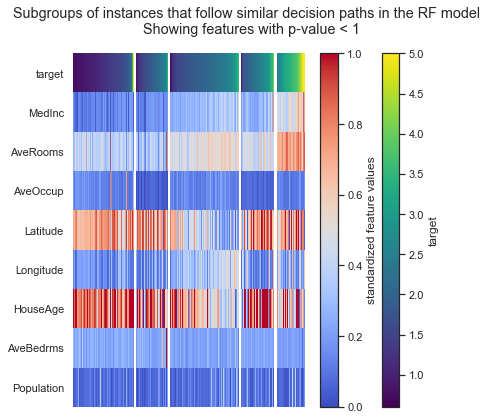

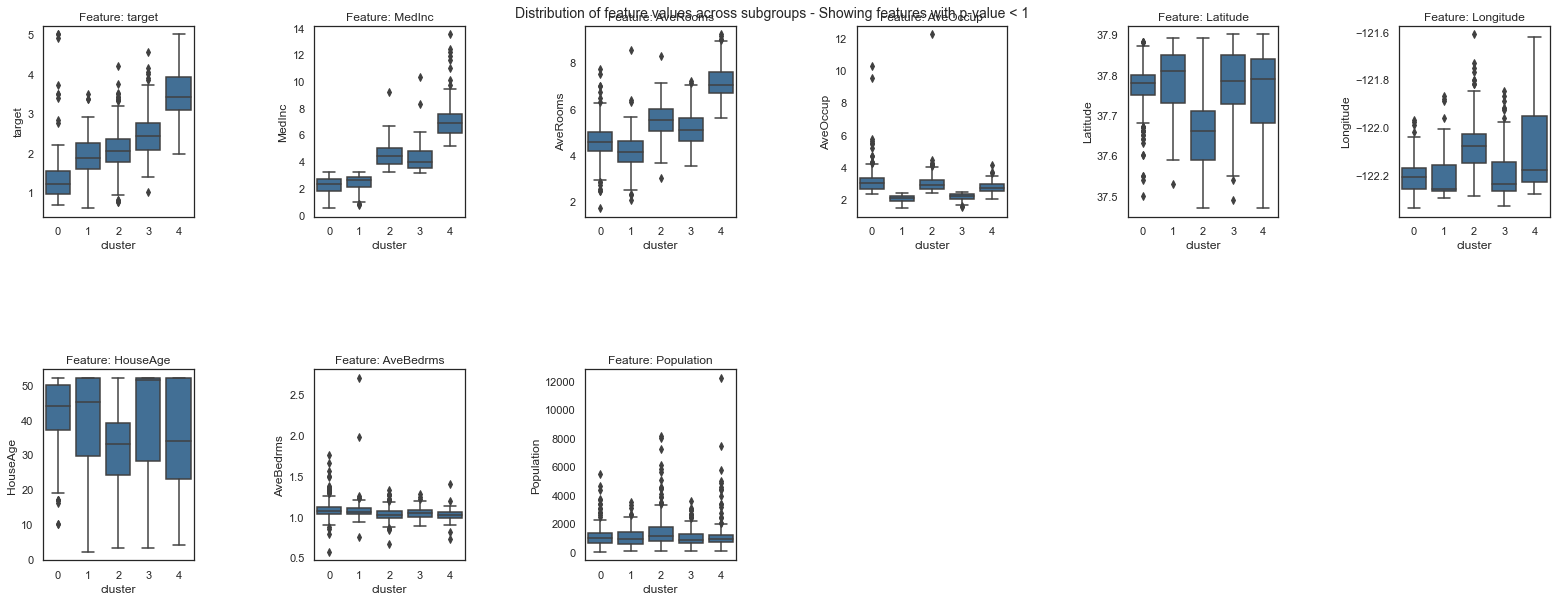

In [7]:
fgc.plot_decision_paths()